# Value Imputation

## Typical-value Imputation

### Typical Tabular Data

In [1]:
from src.setup import *
from src.dermatology import *
df.iloc[:, [0, 1, 2, 3, -2, -1]].sample(6)

,erythema,scaling,definite borders,itching,Age,TARGET
247,2,2,2,0,62,psoriasis
127,2,2,2,2,44,lichen planus
230,3,2,0,1,30,seboreic dermatitis
162,3,2,2,2,22,lichen planus
159,3,2,2,1,47,seboreic dermatitis
296,2,1,1,3,19,cronic dermatitis


In [2]:
clean, suspicious = [], {}
for col in df.columns:
    values = df[col].unique()
    if set(values) <= {0, 1, 2, 3}:
        clean.append(col)
    else:
        suspicious[col] = values

In [3]:
print("No problem detected:")
pprint(clean[:8])
print(f"... {len(clean)-8} other fields")

No problem detected:
['erythema',
 'scaling',
 'definite borders',
 'itching',
 'koebner phenomenon',
 'polygonal papules',
 'follicular papules',
 'oral mucosal involvement']
... 25 other fields


In [4]:
# Notice age has some expected ages and also a '?'
print("Suspicious:")
pprint(suspicious)

Suspicious:
{'Age': array(['55', '8', '26', '40', '45', '41', '18', '57', '22', '30', '20',
       '21', '10', '65', '38', '23', '17', '51', '42', '44', '33', '43',
       '50', '34', '?', '15', '46', '62', '35', '48', '12', '52', '60',
       '32', '19', '29', '25', '36', '13', '27', '31', '28', '64', '39',
       '47', '16', '0', '7', '70', '37', '61', '67', '56', '53', '24',
       '58', '49', '63', '68', '9', '75'], dtype=object),
 'TARGET': array(['seboreic dermatitis', 'psoriasis', 'lichen planus',
       'cronic dermatitis', 'pityriasis rosea',
       'pityriasis rubra pilaris'], dtype=object)}


In [5]:
# Assign missing ages marked with '?' as None
df.loc[df.Age == '?', 'Age'] = None  # or NaN
# Convert string/None ages to floating-point
df['Age'] = df.Age.astype(float)
# Display those rows with missing ages
df.loc[df.Age.isnull()].iloc[:, -4:]

,inflammatory monoluclear inflitrate,band-like infiltrate,Age,TARGET
33,0,0,NaN,psoriasis
34,0,0,NaN,pityriasis rosea
35,0,0,NaN,seboreic dermatitis
36,0,3,NaN,lichen planus
262,3,0,NaN,cronic dermatitis
263,2,0,NaN,cronic dermatitis
264,3,0,NaN,cronic dermatitis
265,3,0,NaN,cronic dermatitis


In [6]:
df.Age.mode()

0    40.0
1    50.0
dtype: float64

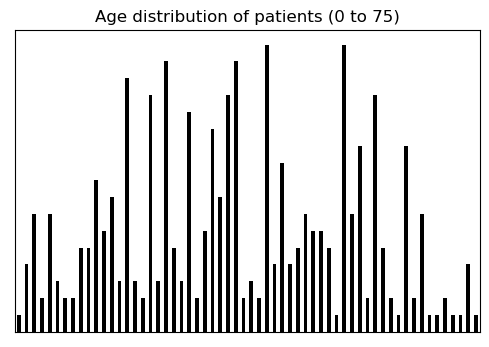

In [7]:
(df.Age
   .value_counts()
   .sort_index()
   .plot(kind="bar", yticks=[], xticks=[], 
         title="Age distribution of patients "
               f"({df.Age.min():.0f} to {df.Age.max():.0f})")
)
plt.savefig("img/(Ch06)Age distribution of patients.png")

In [8]:
df.Age.mean(), df.Age.median()

(36.29608938547486, 35.0)

In [9]:
df.loc[df.Age.isnull(), 'Age'] = df.Age.median()
df.Age.value_counts().head()

35.0    22
50.0    17
40.0    17
36.0    16
27.0    16
Name: Age, dtype: int64

### Locality Imputation

In [10]:
print("Array shape:", digits.shape)

Array shape: (50, 8, 8)


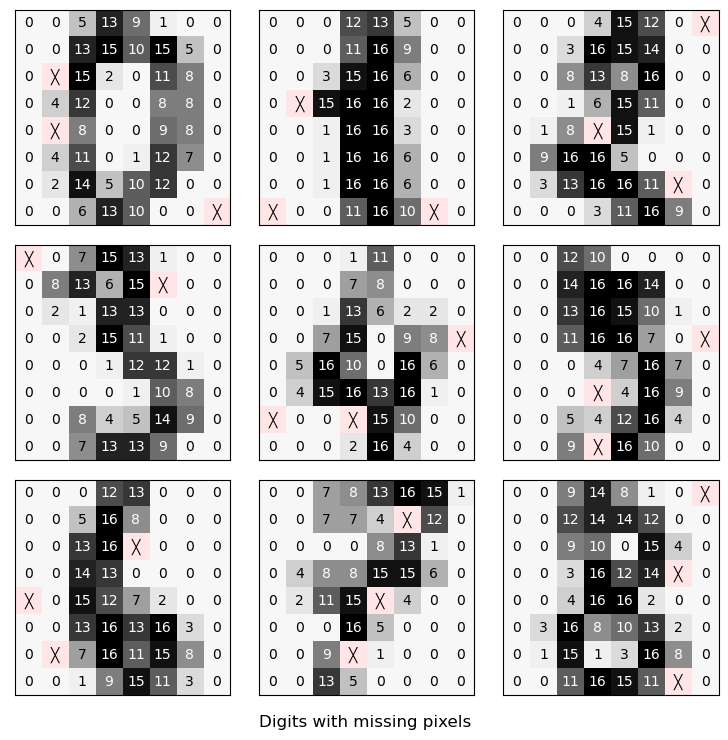

In [11]:
show_digits(digits, title="Digits with missing pixels")

In [12]:
# Coded for clarity, not for best vectorized speed
# Function definition only; used in later cell
def fill_missing(digit):
    digit = digit.copy()
    missing = np.where(digit == -1)
    for y, x in zip(*missing):  # Pull off x/y position of pixel
        # Do not want negative indices in slice
        x_start = max(0, x-1)
        y_start = max(0, y-1)
        # No harm in index larger than size
        x_end = x+2
        y_end = y+2
        # What if another -1 is in region? Remove all the -1s
        region = digit[y_start:y_end, x_start:x_end].flatten()
        region = region[region >=0]
        total = np.sum(region) 
        avg = total // region.size
        digit[y, x] = avg
    return digit

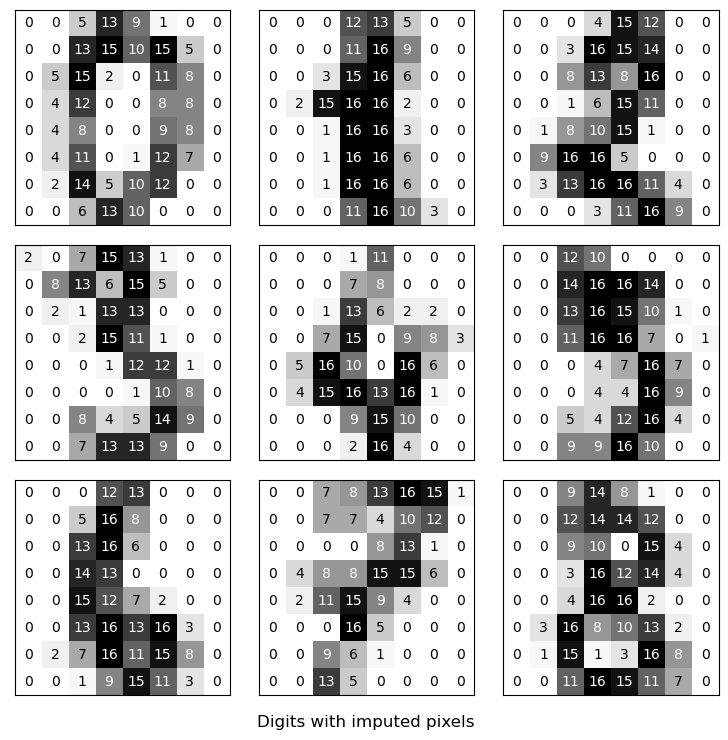

In [13]:
new = np.empty_like(digits)
for n in range(new.shape[0]):
    new[n] = fill_missing(digits[n])

show_digits(new, title="Digits with imputed pixels")

## Trend Imputation

### Types of Trends

In [14]:
date_series

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     NaN
2001-02-05     4.0
dtype: float64

In [15]:
date_series.ffill()  # or .bfill()

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     2.0
2001-02-05     4.0
dtype: float64

In [16]:
date_series.interpolate('linear')

2001-01-01   -10.0
2001-01-05     1.0
2001-01-10     2.0
2001-02-01     3.0
2001-02-05     4.0
dtype: float64

In [17]:
date_series.interpolate('time')

2001-01-01   -10.000000
2001-01-05     1.000000
2001-01-10     2.000000
2001-02-01     3.692308
2001-02-05     4.000000
dtype: float64

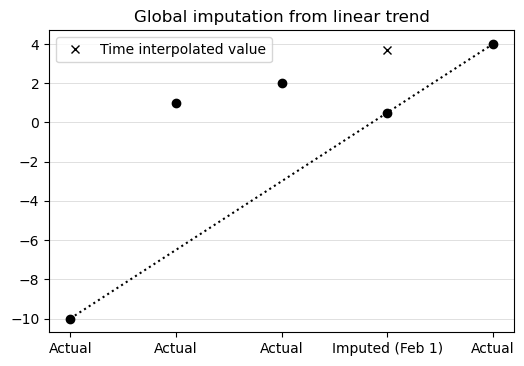

In [18]:
plot_filled_trend(date_series)

In [19]:
from src.dermatology import derm
feat = 'follicular horn plug'
age_groups = derm.groupby(feat).Age.mean()
age_groups

follicular horn plug
0    37.696429
1    20.400000
2    10.625000
3     9.750000
Name: Age, dtype: float64

In [20]:
# The row labels for rows with missing Age
missing = derm.loc[derm.Age.isnull()].index  

# Assign Age based on mapping the feature
derm.loc[missing, 'Age'] = derm[feat].map(age_groups)

# Look at filled data for a few features
derm.loc[missing, [feat, 'scaling', 'itching', 'Age']].head(3)

,follicular horn plug,scaling,itching,Age
33,0,2,0,37.696429
34,0,1,0,37.696429
35,0,2,2,37.696429


### A Larger Coarse Time Series

#### Understanding the Data

In [21]:
parcl = pd.read_json('data/philly_missing.json')
parcl.sample(7, random_state=4) # Random state highlights details

,parcel_number,year,market_value
1862,123018500.0,2014,96100.0
3921,888301242.0,2015,15000.0
617,NaN,2018,0.0
1068,311033500.0,2018,16500.0
11505,888301508.0,2015,15000.0
3843,252327300.0,2014,NaN
10717,314204200.0,2016,41800.0


In [22]:
nparcel = len(parcl[parcl.parcel_number.isnull()])
nmarket = len(parcl[parcl.market_value.isnull()])

print(f"All rows:  {len(parcl):>8,}")
print(f"No parcel: {nparcel:>8,}")
print(f"No market: {nmarket:>8,}")

All rows:    18,290
No parcel:    1,140
No market:      965


In [23]:
parcl = parcl[parcl.parcel_number.notnull()]

print(f"Remaining rows: {len(parcl):,}")

stds = parcl.groupby('parcel_number')['market_value'].std()
(stds // 1000 * 1000).value_counts().head()

Remaining rows: 17,150


0.0       2360
7000.0     114
6000.0     109
2000.0     103
3000.0      83
Name: market_value, dtype: int64

In [24]:
stds[stds == 0].count()

2309

In [25]:
parcl['parcel_number'] = parcl.parcel_number.astype(np.uint32)
parcl['year'] = pd.to_datetime(parcl.year, format="%Y")
parcl.head()

,parcel_number,year,market_value
0,213302600,2016-01-01,196800.0
1,213302600,2015-01-01,196800.0
2,213302600,2014-01-01,196800.0
3,213308200,2018-01-01,198000.0
4,213308200,2017-01-01,198000.0


In [26]:
(parcl
     # Look at those parcels with zero STD among years
     # We calculated those standard deviations as `stds`
     # The `.index` for non-deviation to find parcels
     .loc[parcl.parcel_number.isin(stds[stds == 0].index)]
     # Group by which parcel we are looking at
     .groupby('parcel_number')
     # We care about market values for parcel
     .market_value
     # Aggregation is count of different market values
     .agg('count')
     # Summarize rather than show individual parcels
     .value_counts()
)

5    1767
4     473
3      66
2       3
Name: market_value, dtype: int64

#### Removing Unusable Data

In [27]:
# Parcels that have no change between years (bool array)?
nochange = parcl.parcel_number.isin(stds[stds == 0].index)

# Parcel data grouped by parcel
by_parcel = parcl[nochange].groupby('parcel_number')

# Aggregate on number of market values and compare with 4
few_vals = by_parcel.market_value.count() < 4

# The parcel numbers that have fewer than 4 market values
few_index = few_vals[few_vals == True].index

# What are the actual row numbers we wish to drop
drop_rows = parcl[parcl.parcel_number.isin(few_index)].index

# New name and DataFrame holds the non-dropped rows
parcl2 = parcl.drop(drop_rows)

# We trim from 17,150 rows to 16,817
parcl2

,parcel_number,year,market_value
0,213302600,2016-01-01,196800.0
1,213302600,2015-01-01,196800.0
2,213302600,2014-01-01,196800.0
3,213308200,2018-01-01,198000.0
...,...,...,...
18286,661010710,2016-01-01,215000.0
18287,661010710,2015-01-01,215000.0
18288,661010710,2014-01-01,215000.0
18289,661010720,2018-01-01,215000.0


#### Imputing Consistency

In [28]:
# Aggregate group to find parcels w/ exactly four years
# The `by_parcel` group already assumes no change
four_vals = by_parcel.market_value.count() == 4

# The parcels numbers that have 4 market values
four_index = four_vals[four_vals == True].index

# Row numbers of parcels to impute on
impute_rows = parcl2[parcl2.parcel_number.isin(four_index)].index

# Group parcels only for parcels with 4 market values
by_four = parcl2.loc[impute_rows].groupby('parcel_number')

# Impute the mean (or identically median, etc) to rows
new_vals = by_four.market_value.mean()

# A mapping of SOME parcel numbers to value
new_vals

parcel_number
42204300     30800.0
42205300     33900.0
42206800     30800.0
42207200     30800.0
              ...   
888301511    15000.0
888301512    15000.0
888301814    15000.0
888301815    15000.0
Name: market_value, Length: 473, dtype: float64

In [29]:
# We keep a history of changes in different DFs
parcl3 = parcl2.copy()

# Loop through the new filled values by parcel
for n, (index, val) in enumerate(new_vals.items()):
    # Assignment will fill multiple rows, most redundantly
    parcl3.loc[parcl3.parcel_number == index, 'market_value'] = val
    # Did we start with only four rows in total?
    if len(parcl3.loc[parcl3.parcel_number == index]) == 4:
        print(f"Parcel #{index} has only 4 rows total (all ${val:,.0f})")

Parcel #352055600 has only 4 rows total (all $85,100)
Parcel #541286700 has only 4 rows total (all $116,600)
Parcel #621431100 has only 4 rows total (all $93,800)


In [30]:
assert len(parcl2) == len(parcl3) == 16_817

(parcl3[parcl3.market_value.notnull() &
       (parcl2.market_value != parcl3.market_value)]
     .sort_values('parcel_number'))

,parcel_number,year,market_value
1733,42204300,2018-01-01,30800.0
3718,42205300,2017-01-01,33900.0
1306,42206800,2014-01-01,30800.0
1346,42207200,2014-01-01,30800.0
...,...,...,...
11517,888301511,2018-01-01,15000.0
11525,888301512,2015-01-01,15000.0
7802,888301814,2016-01-01,15000.0
14156,888301815,2015-01-01,15000.0


#### Interpolation

In [31]:
s = pd.Series([None, 1, 2, None, 3, 4, None])
s.interpolate()

0    NaN
1    1.0
2    2.0
3    2.5
4    3.0
5    4.0
6    4.0
dtype: float64

In [32]:
s.interpolate().bfill()

0    1.0
1    1.0
2    2.0
3    2.5
4    3.0
5    4.0
6    4.0
dtype: float64

In [33]:
# Sort data to keep parcels together & years in order
parcl4 = parcl3.sort_values(['parcel_number', 'year'])

# Interpolate per group
parcl4['market_value'] = (
    parcl4
    .groupby('parcel_number')
    .market_value
    .transform(pd.DataFrame.interpolate))

# Back fill per group
parcl4['market_value'] = (
    parcl4
    .groupby('parcel_number')
    .market_value
    .transform(pd.DataFrame.bfill))

In [34]:
print(f"Total rows after operations: {len(parcl4):,}")

# Overlooked missing data
parcl4.loc[parcl4.market_value.isnull()]

Total rows after operations: 16,817


,parcel_number,year,market_value
16461,571291500,2018-01-01,NaN


In [35]:
# As read from disk (other than missing parcels)
parcl.loc[parcl.parcel_number == 571291500]

,parcel_number,year,market_value
16461,571291500,2018-01-01,NaN


### Non-Temporal Trends

In [36]:
krypt = pd.read_fwf('data/excited-kryptonite.fwf')
krypt

,Laser_type_kw,Subtype,Wavelength_nm,Kryptonite_type,candela_per_m2
0,Helium–neon,NaN,632.8,Green,415.837
1,Helium–neon,NaN,543.5,Green,NaN
2,Helium–neon,NaN,593.9,Green,407.308
3,Helium–neon,NaN,611.8,Green,401.305
...,...,...,...,...,...
95,Excimer,ArF,193.0,Gold,611.611
96,Excimer,KrF,248.0,Gold,NaN
97,Excimer,XeCL,308.0,Gold,608.125
98,Excimer,XeF,353.0,Gold,NaN


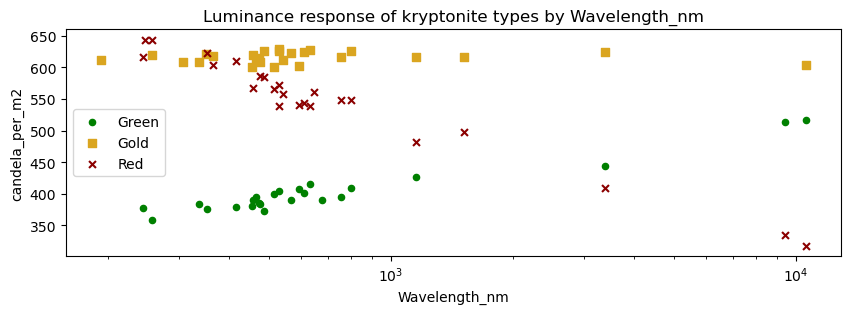

In [37]:
plot_kryptonite()

In [38]:
(krypt[
    (krypt.Wavelength_nm > 1500) & 
    (krypt.Wavelength_nm < 10000)]
 .sort_values('Wavelength_nm'))

,Laser_type_kw,Subtype,Wavelength_nm,Kryptonite_type,candela_per_m2
5,Helium–neon,NaN,1520.0,Green,NaN
38,Helium–neon,NaN,1520.0,Red,497.592
71,Helium–neon,NaN,1520.0,Gold,616.262
6,Helium–neon,NaN,3391.3,Green,444.054
...,...,...,...,...,...
72,Helium–neon,NaN,3391.3,Gold,624.755
28,CO2,NaN,9400.0,Green,514.181
61,CO2,NaN,9400.0,Red,334.444
94,CO2,NaN,9400.0,Gold,NaN


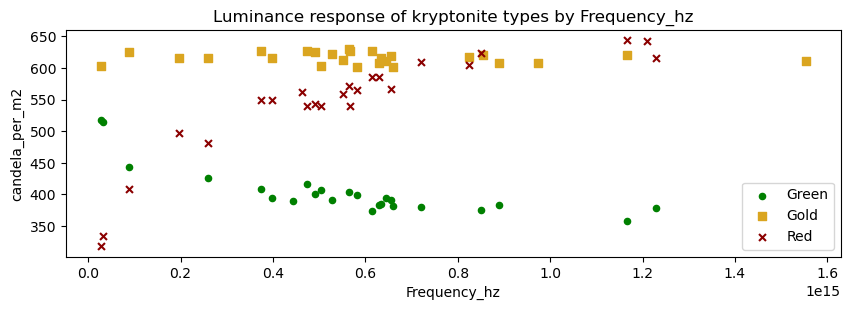

In [39]:
λ = krypt.Wavelength_nm / 10**9   # Wavelength in meters
c = 299_792_458                   # Speed of light in m/s
krypt['Frequency_hz'] = c/λ

# Plot frequency vs luminance
plot_kryptonite(df=krypt, logx=False,
                independent='Frequency_hz')

In [40]:
# Only perform the polyfit on the non-missing data
kr_vals = (krypt[krypt.candela_per_m2.notnull()]
           .sort_values('Frequency_hz'))

# Do a fit for each kryptonite color
for color in ('Red', 'Green', 'Gold'):
    # Limit to the color being fit
    kcolor = kr_vals.loc[kr_vals.Kryptonite_type == color]
    x = kcolor["Frequency_hz"]
    y = kcolor["candela_per_m2"]
    coef2, coef1, offset = np.polyfit(x, y, deg=2)
    
    # Print out the discovered coefficients
    print(f"{color:>5s} (hz → nit): "
          f"{coef2:.1e}*x^2 + {coef1:.1e}*x + {offset:.1e}")

    # Use coefficients to fill missing values
    kmissing = krypt.loc[krypt.candela_per_m2.isnull() & 
                         (krypt.Kryptonite_type == color)]
    x = kmissing.Frequency_hz
    krypt.loc[x.index, 'candela_per_m2'] = (
                            coef2*x**2 + coef1*x + offset)

  Red (hz → nit): -2.6e-28*x^2 + 5.5e-13*x + 3.5e+02
Green (hz → nit): 1.4e-28*x^2 + -2.7e-13*x + 5.0e+02
 Gold (hz → nit): -4.1e-30*x^2 + 2.8e-15*x + 6.2e+02


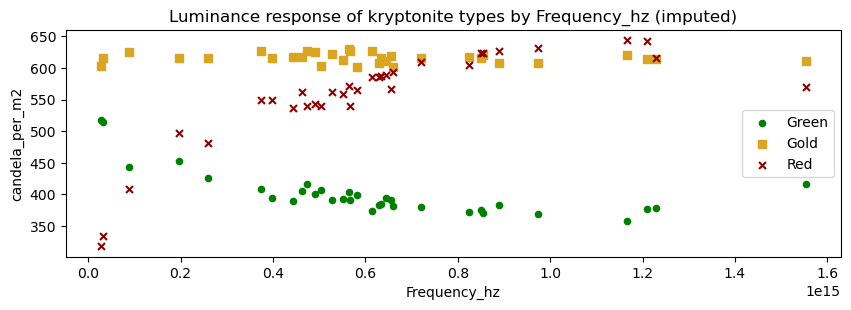

In [41]:
plot_kryptonite(df=krypt, logx=False, imputed=True,
                independent='Frequency_hz')

## Sampling

In [42]:
%load_ext rpy2.ipython

In [43]:
%%capture --no-stdout err
%%R -o humans
library('tidyverse')
humans <- read_csv('data/height-weight.csv')
humans


── Column specification ───────────────────────────────────────────────────────────────────
cols(
  Height = col_double(),
  Weight = col_double()
)

# A tibble: 25,000 x 2
   Height Weight
    <dbl>  <dbl>
 1   167.   51.3
 2   182.   61.9
 3   176.   69.4
 4   173.   64.6
 5   172.   65.5
 6   174.   55.9
 7   177.   64.2
 8   178.   61.9
 9   172.   51.0
10   170.   54.7
# … with 24,990 more rows


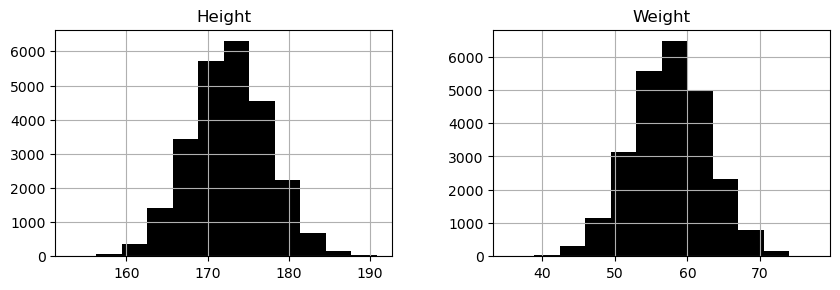

In [44]:
humans.hist(figsize=(10,3), bins=12);
plt.savefig("img/(Ch06)humans-hist-Height_Weight.png")

In [45]:
%%R
table(cut(humans$Height, breaks = 5))


(153,161] (161,168] (168,176] (176,183] (183,191] 
      145      4251     14050      6229       325 


### Undersampling

In [46]:
%%capture --no-stdout err
%%R
cars <- read_csv('data/cars.csv', 
                 col_types = cols("i", "i", "i", "i", "i", "i", "f"))
cars

# A tibble: 1,728 x 7
   price_buy price_maintain doors passengers trunk safety rating      
       <int>          <int> <int>      <int> <int>  <int> <fct>       
 1         1              0     3          6     0      0 Unacceptable
 2         2              2     3          6     2      1 Acceptable  
 3         2              2     5          2     1      1 Unacceptable
 4         0              1     3          2     2      1 Unacceptable
 5         2              1     5          2     0      1 Unacceptable
 6         3              1     2          6     2      1 Acceptable  
 7         0              2     4          4     0      0 Unacceptable
 8         1              2     2          4     2      0 Unacceptable
 9         1              0     4          4     0      1 Acceptable  
10         1              3     3          2     0      0 Unacceptable
# … with 1,718 more rows


In [47]:
%%R
table(cars$rating)


Unacceptable   Acceptable    Very Good         Good 
        1210          384           65           69 


In [48]:
%%R
unacc <- sample(which(cars$rating == "Unacceptable"), 100)
acc <- sample(which(cars$rating == "Acceptable"), 100)
good <- sample(which(cars$rating == "Good"), 69)
vgood <- sample(which(cars$rating == "Very Good"), 65)
samples <- slice(cars, c(vgood, good, acc, unacc))
samples

# A tibble: 334 x 7
   price_buy price_maintain doors passengers trunk safety rating   
       <int>          <int> <int>      <int> <int>  <int> <fct>    
 1         0              0     5          6     2      2 Very Good
 2         1              1     3          6     2      2 Very Good
 3         0              1     5          6     1      2 Very Good
 4         0              1     5          6     2      2 Very Good
 5         0              1     4          4     1      2 Very Good
 6         0              1     5          4     1      2 Very Good
 7         0              1     3          6     2      2 Very Good
 8         1              0     5          6     2      2 Very Good
 9         0              0     5          4     1      2 Very Good
10         0              1     5          4     2      2 Very Good
# … with 324 more rows


In [49]:
%%R
samples %>%
  group_by(rating) %>%
  count()

# A tibble: 4 x 2
# Groups:   rating [4]
  rating           n
  <fct>        <int>
1 Unacceptable   100
2 Acceptable     100
3 Very Good       65
4 Good            69


In [50]:
%%R
# Find indices for each class (dups OK)
indices <- unlist(
  lapply(
    # For each level of the rating factor,
    levels(cars$rating), 
    # sample with replacement 150 indices
    function(rating) {
      pred <- which(cars$rating == rating)
      sample(pred, 150, replace = TRUE) }))

# Check that we have drawn evenly
slice(cars, indices) %>%
  group_by(rating) %>%
  count()

# A tibble: 4 x 2
# Groups:   rating [4]
  rating           n
  <fct>        <int>
1 Unacceptable   150
2 Acceptable     150
3 Very Good      150
4 Good           150


### Oversampling

In [51]:
# Read the raw data and count most common rating
cars = pd.read_csv('data/cars.csv')
cars2 = cars.copy()  # Modify a copy of DataFrame
most_common = max(cars2.rating.value_counts())

for rating in cars2.rating.unique():
    # A DataFrame of only one rating class
    rating_class = cars2[cars2.rating == rating]
    # Duplicate one less than overshooting most_common
    num_dups = (most_common // len(rating_class)) - 1
    for _ in range(num_dups):
        cars2 = pd.concat([cars2, rating_class])

cars2.rating.value_counts()

Unacceptable    1210
Good            1173
Very Good       1170
Acceptable      1152
Name: rating, dtype: int64

In [52]:
cars.rating.value_counts()

Unacceptable    1210
Acceptable       384
Good              69
Very Good         65
Name: rating, dtype: int64

In [53]:
# Only define the feature and target matrices, use in next cell
from imblearn.over_sampling import SMOTE

# Divide data frame into X features and y target
X = cars.drop('rating', axis=1)
y = cars['rating']

# Create the resamples features/target
X_res, y_res = SMOTE(k_neighbors=4).fit_resample(X, y)

In [54]:
synth_cars = X_res.copy()
synth_cars['rating'] = y_res
synth_cars.sample(8, random_state=2)

,price_buy,price_maintain,doors,passengers,trunk,safety,rating
748,2,2,5,6,0,0,Unacceptable
72,0,3,2,6,0,1,Unacceptable
2213,3,0,2,4,0,2,Acceptable
1686,2,3,5,2,0,0,Unacceptable
3578,0,0,4,6,1,1,Good
3097,0,0,2,4,0,2,Good
4818,0,1,4,4,1,2,Very Good
434,2,3,5,6,2,0,Unacceptable


In [55]:
synth_cars.rating.value_counts()

Very Good       1210
Unacceptable    1210
Good            1210
Acceptable      1210
Name: rating, dtype: int64

In [56]:
cars.iloc[:, :6] = cars.iloc[:, :6].astype(float)
cars.head()

,price_buy,price_maintain,doors,passengers,trunk,safety,rating
0,1.0,0.0,3.0,6.0,0.0,0.0,Unacceptable
1,2.0,2.0,3.0,6.0,2.0,1.0,Acceptable
2,2.0,2.0,5.0,2.0,1.0,1.0,Unacceptable
3,0.0,1.0,3.0,2.0,2.0,1.0,Unacceptable
4,2.0,1.0,5.0,2.0,0.0,1.0,Unacceptable


In [57]:
# Divide data frame into X features and y target
X = cars.drop('rating', axis=1)
y = cars['rating']

# Create the resamples features/target
X_, y_ = SMOTE().fit_resample(X, y)
pd.concat([X_, y_], axis=1).sample(6, random_state=4)

,price_buy,price_maintain,doors,passengers,trunk,safety,rating
4304,1.0,0.158397,2.158397,6.0,2.0000,2.0,Very Good
337,3.0,0.000000,3.000000,4.0,0.0000,1.0,Unacceptable
2360,2.0,2.000000,3.247795,4.0,2.0000,2.0,Acceptable
3352,0.0,1.000000,2.123895,4.0,2.0000,1.0,Good
2064,0.0,3.000000,4.000000,6.0,1.8577,2.0,Acceptable
4058,1.0,0.000000,3.075283,6.0,2.0000,2.0,Very Good


## Exercises

### Balancing Multiple Features

In [58]:
humcol = pd.read_csv('data/height-weight-color.csv')
humcol.sample(6, random_state=1)

,Height,Weight,Favorite
21492,176.958650,72.604585,red
9488,169.000221,79.559843,blue
16933,171.104306,71.125528,red
12604,174.481084,79.496237,blue
8222,171.275578,77.094118,green
9110,164.631065,70.557834,green


In [59]:
pd.cut(humcol.Weight, 5).value_counts().sort_index()

(44.692, 55.402]      125
(55.402, 66.06]      3708
(66.06, 76.717]     14074
(76.717, 87.375]     6700
(87.375, 98.033]      393
Name: Weight, dtype: int64